# Linear Bivariate BMM with calibration of Coleman toy models.

The best way to learn Taweret is to use it. You can run, modify and experiment with this notebook on [GitHub Codespaces](https://github.com/bandframework/Taweret).

The models can be found in Coleman Thesis : https://go.exlibris.link/3fVZCfhl

This notebook shows how to use the Bayesian model mixing package **Taweret** for a toy problem. 

**Author : Dan Liyanage**

Date : 11/13/2022

In [1]:
import sys
import os
# You will have to change the following imports depending on where you have 
# the packages installed

cwd = os.getcwd()

# Get the first part of this path and append to the sys.path
tw_path = cwd.split("Taweret/")[0] + "Taweret"
sys.path.append(tw_path)

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
# To define priors. (uncoment if not using default priors)
#import bilby

# For other operations
import numpy as np

In [2]:
# Import models with a predict method
from Taweret.models import coleman_models as toy_models

m1 = toy_models.coleman_model_1()
m2 = toy_models.coleman_model_2()
truth = toy_models.coleman_truth()

In [3]:
g = np.linspace(-1,9,10)
plot_g = np.linspace(-1,9,100)
true_output = truth.evaluate(plot_g)
exp_data = truth.evaluate(g)

## 1. The models and the experimental data.

Truth
 
$f(x) = 2-0.1(x-4)^2$, where $x \in [-1, 9]$

Model 1

$f_1(x,\theta)= 0.5(x+\theta)-2$    , where $\theta \in [1, 6]$

Model 2

$f_2(x,\theta)= -0.5(x-\theta) + 3.7$   , where $\theta \in [-2, 3]$

Experimental data 

sampled from the Truth with a fixed standard deviation of 0.3




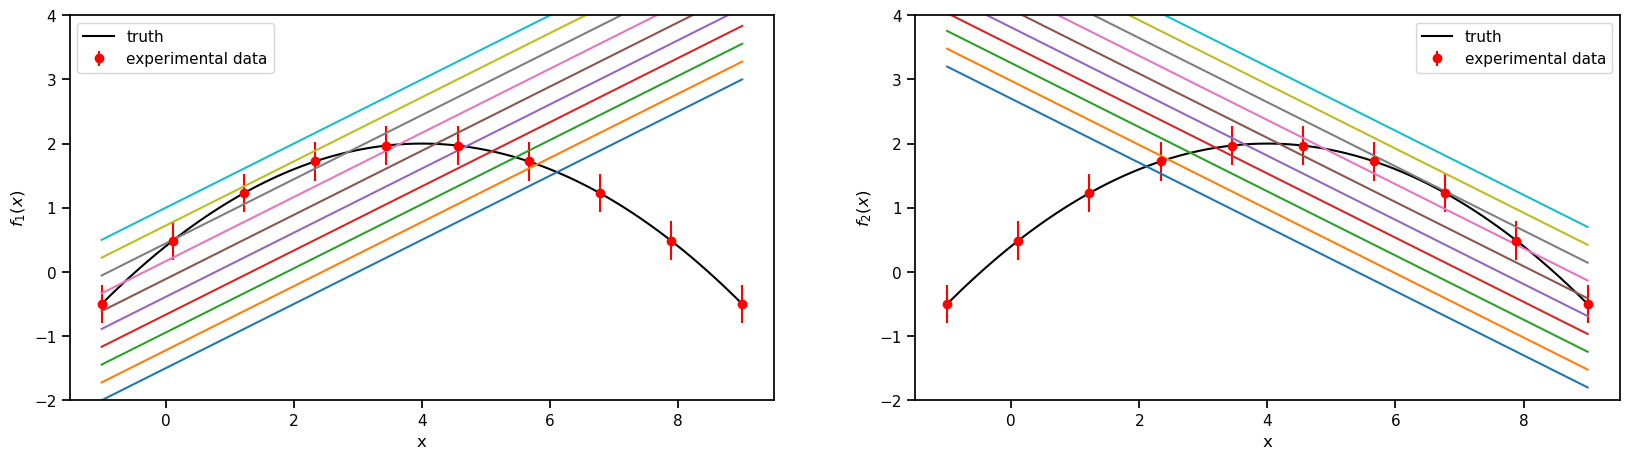

In [4]:
sns.set_context('notebook')
fig, axs = plt.subplots(1,2,figsize=(20,5))
prior_ranges = [(1,6), (-2,3)]
for i in range(0,2):
    ax = axs.flatten()[i]
    ax.plot(plot_g, true_output[0], label='truth', color='black')
    ax.errorbar(g,exp_data[0],exp_data[1], fmt='o', label='experimental data', color='r')
    ax.legend()
    ax.set_ylim(-2,4)
    for value in np.linspace(*prior_ranges[i],10):
        if i==0:
            predict_1 = m1.evaluate(plot_g, value)
            ax.plot(plot_g, predict_1[0])
            ax.set_ylabel(r'$f_1(x)$')
        if i==1:
            predict_2 = m2.evaluate(plot_g, value)
            ax.plot(plot_g, predict_2[0])      
            ax.set_ylabel(r'$f_2(x)$')    
    ax.set_xlabel('x') 
    


##  2. Choose a Mixing method

In [7]:
# Mixing method
from Taweret.mix.bivariate_linear import BivariateLinear as BL

models= {'model1':m1,'model2':m2}
mix_model = BL(models_dic=models, method='cdf', nargs_model_dic={'model1':1, 'model2':1})

cdf mixing function has 2                   free parameter(s)
To change the prior use `set_prior` method
Using default priors for model 1
{'model1_0': Uniform(minimum=1, maximum=6, name='model1_0', latex_label='model1_0', unit=None, boundary=None)}
Using default priors for model 2
{'model2_0': Uniform(minimum=-2, maximum=3, name='model2_0', latex_label='model2_0', unit=None, boundary=None)}


In [8]:
## uncoment to change the prior from the default
import bilby 

priors = bilby.core.prior.PriorDict()
priors['cdf_0'] = bilby.core.prior.Normal(0, 1, name="cdf_0")
priors['cdf_1'] = bilby.core.prior.Normal(0, 1, name="cdf_1")
mix_model.set_prior(priors)

{'cdf_0': Normal(mu=0, sigma=1, name='cdf_0', latex_label='cdf_0', unit=None, boundary=None),
 'cdf_1': Normal(mu=0, sigma=1, name='cdf_1', latex_label='cdf_1', unit=None, boundary=None),
 'model1_0': Uniform(minimum=1, maximum=6, name='model1_0', latex_label='model1_0', unit=None, boundary=None),
 'model2_0': Uniform(minimum=-2, maximum=3, name='model2_0', latex_label='model2_0', unit=None, boundary=None)}

In [9]:
mix_model.prior

{'cdf_0': Normal(mu=0, sigma=1, name='cdf_0', latex_label='cdf_0', unit=None, boundary=None),
 'cdf_1': Normal(mu=0, sigma=1, name='cdf_1', latex_label='cdf_1', unit=None, boundary=None),
 'model1_0': Uniform(minimum=1, maximum=6, name='model1_0', latex_label='model1_0', unit=None, boundary=None),
 'model2_0': Uniform(minimum=-2, maximum=3, name='model2_0', latex_label='model2_0', unit=None, boundary=None)}

## 3. Train to find posterior

In [10]:
kwargs_for_sampler = {'sampler': 'ptemcee',
                    'ntemps': 5,
                    'nwalkers': 50,
                    'Tmax': 100,
                    'burn_in_fixed_discard': 50,
                    'nsamples': 2000,
                    'threads': 6,
                    'printdt': 60}

result = mix_model.train(x_exp=g, y_exp=exp_data[0], y_err=exp_data[1],
                        label='cdf_mix', 
                        outdir='outdir/coleman', 
                        kwargs_for_sampler=kwargs_for_sampler,
                        load_previous=True)

/Users/alexandra/Documents/Taweret/Taweret/mix/bivariate_linear.py:639: UserWarning: 'threads' dectected in 'kwargs_for_sampler' on Darwin. Setting `start_method` to `fork`
  warnings.warn("'threads' dectected in 'kwargs_for_sampler'" +
10:03 bilby INFO    : Running for label 'cdf_mix', output will be saved to 'outdir/coleman'


Saved results for cdf_mix do not exist in : outdir/coleman
The following settings were                     provided for sampler 
{'sampler': 'ptemcee', 'ntemps': 5, 'nwalkers': 50, 'Tmax': 100, 'burn_in_fixed_discard': 50, 'nsamples': 2000, 'threads': 6, 'printdt': 60}


10:03 bilby INFO    : Analysis priors:
10:03 bilby INFO    : cdf_0=Normal(mu=0, sigma=1, name='cdf_0', latex_label='cdf_0', unit=None, boundary=None)
10:03 bilby INFO    : cdf_1=Normal(mu=0, sigma=1, name='cdf_1', latex_label='cdf_1', unit=None, boundary=None)
10:03 bilby INFO    : model1_0=Uniform(minimum=1, maximum=6, name='model1_0', latex_label='model1_0', unit=None, boundary=None)
10:03 bilby INFO    : model2_0=Uniform(minimum=-2, maximum=3, name='model2_0', latex_label='model2_0', unit=None, boundary=None)
10:03 bilby INFO    : Analysis likelihood class: <class 'Taweret.sampler.likelihood_wrappers.likelihood_wrapper_for_bilby'>
10:03 bilby INFO    : Analysis likelihood noise evidence: nan
10:03 bilby INFO    : Single likelihood evaluation took 1.116e-04 s
10:03 bilby WARNING : Supplied argument 'printdt' not an argument of 'Ptemcee', removing.
10:03 bilby INFO    : Using sampler Ptemcee with kwargs {'ntemps': 5, 'nwalkers': 50, 'Tmax': 100, 'betas': None, 'a': 2.0, 'adaptation_la

1|0:00:00|nc:1.2e+03|a0:0.00-1.00|swp:0.34-0.72|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.07ms/ev
2|0:00:00|nc:2.5e+03|a0:0.20-0.80|swp:0.25-0.69|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.28ms/ev
3|0:00:00|nc:3.8e+03|a0:0.27-0.73|swp:0.22-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.19ms/ev
4|0:00:00|nc:5.0e+03|a0:0.35-0.75|swp:0.23-0.66|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.18ms/ev
5|0:00:00|nc:6.2e+03|a0:0.36-0.72|swp:0.23-0.66|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.03ms/ev
6|0:00:00|nc:7.5e+03|a0:0.30-0.70|swp:0.24-0.65|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.03ms/ev
7|0:00:00|nc:8.8e+03|a0:0.34-0.69|swp:0.23-0.65|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.03ms/ev
8|0:00:00|nc:1.0e+04|a0:0.38-0.68|swp:0.23-0.64|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.03ms/ev
9|0:00:00|nc:1.1e+04|a0:0.38-0.71|swp:0.24-0.63|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.03ms/ev
10|0:00:00|nc:1.2e+04|a0:0.38-0.68|swp:0.24-0.63|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.03ms/ev
11|0:00:00|nc:1.4e+04|a0:0.36-0.69|swp:0.24-0.63|n:nan<2000|t!nan(+nan,+nan)|q:

90|0:00:03|nc:1.1e+05|a0:0.54-0.65|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.03ms/ev
91|0:00:03|nc:1.1e+05|a0:0.55-0.65|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.02ms/ev
92|0:00:03|nc:1.2e+05|a0:0.54-0.65|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.02ms/ev
93|0:00:03|nc:1.2e+05|a0:0.54-0.65|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.02ms/ev
94|0:00:03|nc:1.2e+05|a0:0.54-0.65|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.02ms/ev
95|0:00:03|nc:1.2e+05|a0:0.54-0.65|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.02ms/ev
96|0:00:03|nc:1.2e+05|a0:0.54-0.65|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.02ms/ev
97|0:00:03|nc:1.2e+05|a0:0.54-0.64|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.02ms/ev
98|0:00:03|nc:1.2e+05|a0:0.54-0.64|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.02ms/ev
99|0:00:03|nc:1.2e+05|a0:0.54-0.64|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.02ms/ev
100|0:00:03|nc:1.2e+05|a0:0.54-0.64|swp:0.27-0.67|n:nan<2000|t!nan(+na

177|0:00:06|nc:2.2e+05|a0:0.53-0.62|swp:0.27-0.67|n:-150<2000|t!2(+0.02,+0.26)|q:1.01|0.03ms/ev
178|0:00:06|nc:2.2e+05|a0:0.53-0.62|swp:0.27-0.67|n:-100<2000|t!2(+0.03,+0.56)|q:1.01|0.03ms/ev
179|0:00:06|nc:2.2e+05|a0:0.54-0.62|swp:0.27-0.67|n:-50<2000|t!2(+0.03,+0.53)|q:1.01|0.03ms/ev
180|0:00:06|nc:2.2e+05|a0:0.53-0.62|swp:0.27-0.67|n:0<2000|t!2(+0.02,+0.22)|q:1.01|0.03ms/ev
181|0:00:06|nc:2.3e+05|a0:0.53-0.62|swp:0.26-0.67|n:50<2000|t!2(+0.02,+0.33)|q:1.01|0.03ms/ev
182|0:00:06|nc:2.3e+05|a0:0.53-0.62|swp:0.26-0.67|n:100<2000|t!2(+0.03,+0.17)|q:1.01|0.03ms/ev
183|0:00:06|nc:2.3e+05|a0:0.53-0.62|swp:0.26-0.67|n:150<2000|t!2(+0.06,+0.20)|q:1.01|0.03ms/ev
184|0:00:07|nc:2.3e+05|a0:0.54-0.62|swp:0.26-0.67|n:200<2000|t!2(+0.02,+0.38)|q:1.01|0.03ms/ev
185|0:00:07|nc:2.3e+05|a0:0.54-0.62|swp:0.26-0.67|n:250<2000|t!2(+0.02,+0.30)|q:1.01|0.03ms/ev
186|0:00:07|nc:2.3e+05|a0:0.54-0.62|swp:0.26-0.67|n:300<2000|t!2(+0.02,+0.58)|q:1.01|0.03ms/ev
187|0:00:07|nc:2.3e+05|a0:0.54-0.62|swp:0.26-0.67|n

263|0:00:09|nc:3.3e+05|a0:0.56-0.61|swp:0.27-0.67|n:1950<2000|t!2(+0.03,+0.45)|q:1.00|0.03ms/ev
264|0:00:09|nc:3.3e+05|a0:0.56-0.61|swp:0.27-0.67|n:2000<2000|t!2(+0.03,+0.11)|q:1.00|0.03ms/ev
265|0:00:10|nc:3.3e+05|a0:0.56-0.61|swp:0.27-0.67|n:2050<2000|t!2(+0.02,+0.27)|q:1.00|0.03ms/ev
266|0:00:10|nc:3.3e+05|a0:0.56-0.61|swp:0.27-0.67|n:2100<2000|t!2(+0.03,+0.23)|q:1.00|0.03ms/ev
267|0:00:10|nc:3.3e+05|a0:0.56-0.61|swp:0.27-0.67|n:2150<2000|t!2(+0.04,+0.31)|q:1.00|0.03ms/ev
268|0:00:10|nc:3.4e+05|a0:0.56-0.61|swp:0.27-0.67|n:2200<2000|t!2(+0.02,+0.43)|q:1.00|0.03ms/ev
269|0:00:10|nc:3.4e+05|a0:0.56-0.61|swp:0.27-0.67|n:2250<2000|t!2(+0.01,+0.21)|q:1.00|0.03ms/ev
270|0:00:10|nc:3.4e+05|a0:0.55-0.61|swp:0.27-0.67|n:2300<2000|t!2(+0.02,+0.24)|q:1.00|0.03ms/ev
271|0:00:10|nc:3.4e+05|a0:0.55-0.61|swp:0.27-0.67|n:2350<2000|t!2(+0.03,+0.36)|q:1.00|0.03ms/ev
272|0:00:10|nc:3.4e+05|a0:0.56-0.61|swp:0.27-0.67|n:2400<2000|t!2(+0.02,+0.20)|q:1.00|0.03ms/ev
273|0:00:10|nc:3.4e+05|a0:0.56-0.61|swp:

350|0:00:12|nc:4.4e+05|a0:0.56-0.60|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.03ms/ev
351|0:00:12|nc:4.4e+05|a0:0.56-0.60|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.03ms/ev
352|0:00:13|nc:4.4e+05|a0:0.56-0.60|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.03ms/ev
353|0:00:13|nc:4.4e+05|a0:0.56-0.60|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.03ms/ev
354|0:00:13|nc:4.4e+05|a0:0.56-0.60|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.03ms/ev
355|0:00:13|nc:4.4e+05|a0:0.56-0.60|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.03ms/ev
356|0:00:13|nc:4.4e+05|a0:0.56-0.60|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.02ms/ev
357|0:00:13|nc:4.5e+05|a0:0.56-0.60|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.02ms/ev
358|0:00:13|nc:4.5e+05|a0:0.56-0.60|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.02ms/ev
359|0:00:13|nc:4.5e+05|a0:0.56-0.60|swp:0.27-0.67|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.03ms/ev
360|0:00:13|nc:4.5e+05|a0:0.56-0.60|swp:0.27-0.67|n:nan<2000

436|0:00:16|nc:5.4e+05|a0:0.56-0.60|swp:0.27-0.67|n:1000<2000|t!2(+0.04,+0.27)|q:1.01|0.03ms/ev
437|0:00:16|nc:5.5e+05|a0:0.56-0.60|swp:0.27-0.67|n:1050<2000|t!2(+0.02,+0.17)|q:1.01|0.03ms/ev
438|0:00:16|nc:5.5e+05|a0:0.56-0.60|swp:0.27-0.67|n:1100<2000|t!2(+0.02,+0.19)|q:1.01|0.03ms/ev
439|0:00:16|nc:5.5e+05|a0:0.56-0.60|swp:0.27-0.67|n:1150<2000|t!2(+0.02,+0.27)|q:1.01|0.03ms/ev
440|0:00:16|nc:5.5e+05|a0:0.56-0.60|swp:0.27-0.67|n:1200<2000|t!2(+0.04,+0.26)|q:1.01|0.03ms/ev
441|0:00:16|nc:5.5e+05|a0:0.56-0.60|swp:0.27-0.67|n:1250<2000|t!2(+0.01,+0.31)|q:1.01|0.03ms/ev
442|0:00:16|nc:5.5e+05|a0:0.56-0.60|swp:0.27-0.67|n:1300<2000|t!2(+0.01,+0.33)|q:1.00|0.03ms/ev
443|0:00:16|nc:5.5e+05|a0:0.56-0.60|swp:0.27-0.67|n:1350<2000|t!2(+0.02,+0.35)|q:1.00|0.03ms/ev
444|0:00:16|nc:5.6e+05|a0:0.56-0.60|swp:0.27-0.67|n:1400<2000|t!2(+0.02,+0.28)|q:1.00|0.03ms/ev
445|0:00:16|nc:5.6e+05|a0:0.56-0.60|swp:0.27-0.67|n:1450<2000|t!2(+0.02,+0.12)|q:1.00|0.03ms/ev
446|0:00:16|nc:5.6e+05|a0:0.56-0.60|swp:

10:03 bilby INFO    : Finished sampling
10:03 bilby INFO    : Writing checkpoint and diagnostics
10:03 bilby INFO    : Finished writing checkpoint
10:03 bilby INFO    : Sampling time: 0:00:17.999632
10:03 bilby INFO    : Summary of results:
nsamples: 3650
ln_noise_evidence:    nan
ln_evidence: -9.482 +/-  3.012
ln_bayes_factor:    nan +/-  3.012



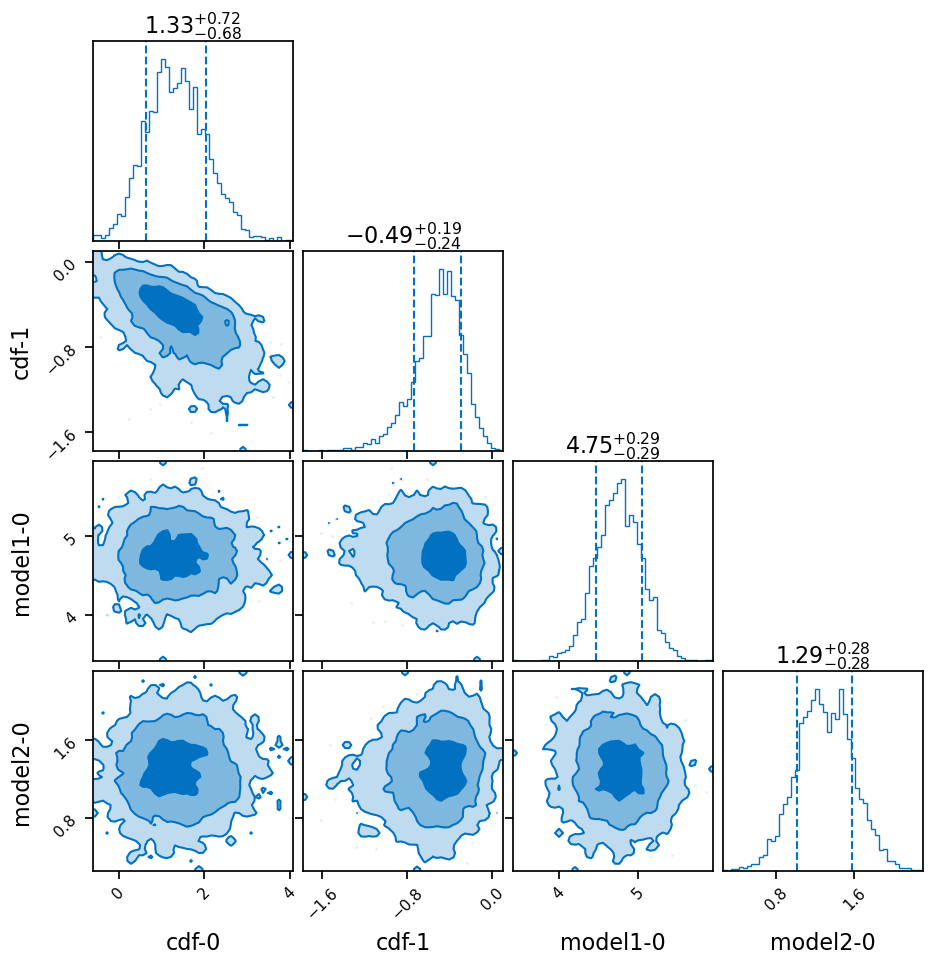

In [11]:
result.plot_corner()

### 4. Predictions

In [12]:
_,mean_prior,CI_prior, _ = mix_model.prior_predict(plot_g, CI=[5,20,80,95])
_,mean,CI, _ = mix_model.predict(plot_g, CI=[5,20,80,95])

(10000, 4)
using provided samples instead of posterior


In [13]:
per5, per20, per80, per95 = CI
prior5, prior20, prior80, prior95 = CI_prior

In [14]:
mix_model.map

array([ 2.96825776, -0.80797699,  4.7239345 ,  1.44454939])

In [15]:
# Map value prediction for the step mixing function parameter
model_params = [np.array(mix_model.map[2]), np.array(mix_model.map[3])]
map_prediction = mix_model.evaluate(mix_model.map[0:2], plot_g, model_params=model_params)

In [16]:
_,_,CI_weights,_=mix_model.predict_weights(plot_g, CI=[5,20, 80, 95])
perw_5, perw_20, perw_80, perw_95 = CI_weights

(3650, 100)


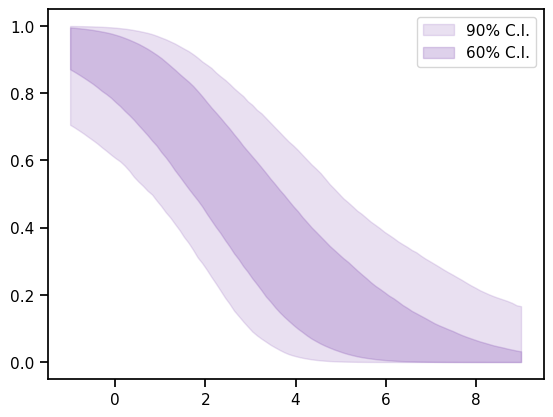

In [17]:
%matplotlib inline
fig, ax = plt.subplots()
ax.fill_between(plot_g,perw_5,perw_95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,perw_20,perw_80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
ax.legend()
#ax.plot(plot_g, true_output[0], label='truth')
#ax.set_ylim(1.2,3.2)

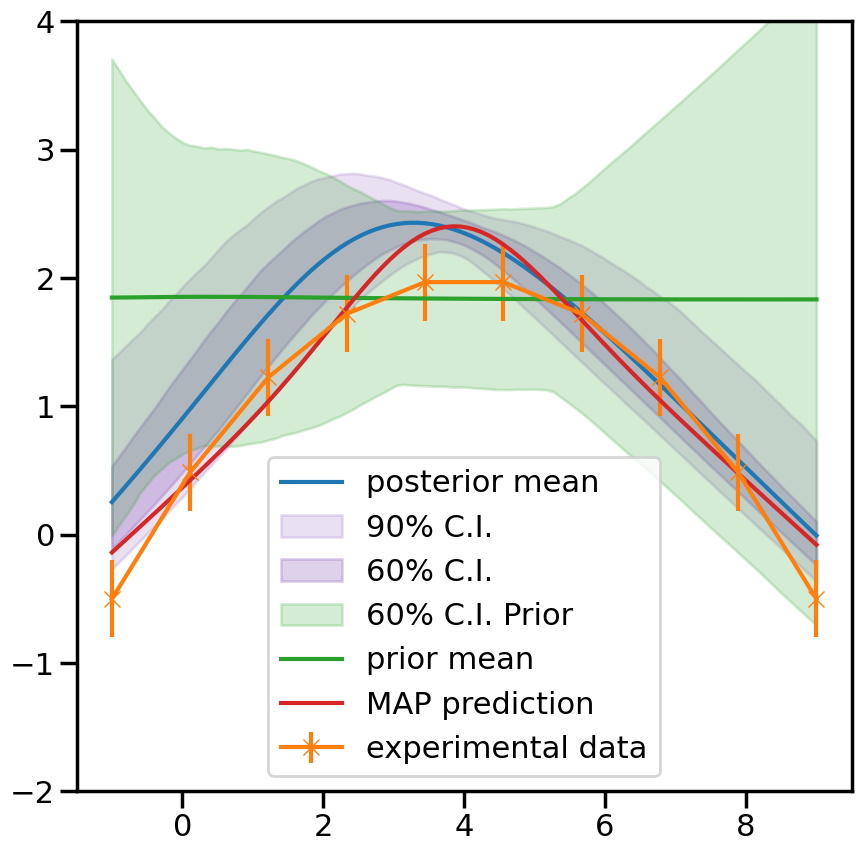

In [18]:
%matplotlib inline
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(plot_g, mean.flatten(), label='posterior mean')
ax.fill_between(plot_g,per5.flatten(),per95.flatten(),color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,per20.flatten(),per80.flatten(), color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
ax.fill_between(plot_g,prior20.flatten(),prior80.flatten(),color=sns.color_palette()[2], alpha=0.2, label='60% C.I. Prior')
ax.errorbar(g,exp_data[0],yerr=exp_data[1], marker='x', label='experimental data')
ax.plot(plot_g, mean_prior.flatten(), label='prior mean')
ax.plot(plot_g, map_prediction.flatten(), label='MAP prediction')
ax.set_ybound(-2,4)
ax.legend()